In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import joblib
from sklearn.linear_model import LinearRegression

In [2]:
# Load the data
data = pd.read_csv('../dataset/node1_data.csv')
data['needs_charge'] = np.where(data['charge'] <= 50, 1, 0)

DATA CLEANING

In [3]:
# Data Cleaning
data = pd.get_dummies(data, columns=['weather', 'traffic', 'road_gradient', 'emergency', 'car_status'])
data = data.drop_duplicates()
data = data.select_dtypes(include=[float, int])
# Check the column names
print(data.columns)

Index(['current_speed', 'battery_capacity', 'charge', 'consumption',
       'location', 'distance_covered', 'battery_life',
       'distance_to_charging_point', 'emergency_duration', 'needs_charge'],
      dtype='object')


Feature Selection

In [4]:
# Feature Selection
features = ['current_speed', 'battery_capacity', 'charge', 'consumption', 'distance_covered', 'battery_life', 'distance_to_charging_point']
features += [col for col in data if 'weather_' in col]
features += [col for col in data if 'traffic_' in col]
features += [col for col in data if 'road_gradient_' in col]
features += [col for col in data if 'emergency_' in col]
features += [col for col in data if 'car_status_' in col]

X = data[features]
y = data['needs_charge']

print(X.head())

   current_speed  battery_capacity     charge  consumption  distance_covered  \
0             21                50  68.879922         0.13          0.833333   
1             43                50  77.714729         0.12          1.333333   
2             53                50  77.633644         0.12          2.050000   
3             52                50  77.509634         0.12          2.933333   
4             32                50  77.390325         0.12          3.800000   

   battery_life  distance_to_charging_point  emergency_duration  
0        97.999                   39.166667                   0  
1        98.999                   88.666667                   0  
2        98.998                   87.950000                   0  
3        98.997                   87.066667                   0  
4        98.996                   86.200000                   0  


In [5]:
# Create a copy of the DataFrame slice
X = X.copy()

# Display columns which contain 'inf' or '-inf' values
inf_columns = X.columns[X.isin([float('inf'), -float('inf')]).any()].tolist()
print(f"Columns with inf values: {inf_columns}")

# Replace 'inf' and '-inf' values in those columns with NaN
for col in inf_columns:
    X[col].replace([float('inf'), -float('inf')], float('nan'), inplace=True)

for col in inf_columns:
    X[col].fillna(X[col].mean(), inplace=True)

Columns with inf values: []


In [6]:
# Initialize the model with higher max_iter
model = LogisticRegression(max_iter=1000)

# Initialize RFE
rfe = RFE(model, n_features_to_select=10)

# Fit RFE
fit = rfe.fit(X, y)

# Get the selected features
selected_features = X.columns[fit.support_]
print("Selected Features: ", selected_features)

Selected Features:  Index(['current_speed', 'battery_capacity', 'charge', 'consumption',
       'distance_covered', 'battery_life', 'distance_to_charging_point',
       'emergency_duration'],
      dtype='object')


In [7]:
print(data['charge'].describe())
print(data['needs_charge'].value_counts())

count    9662.000000
mean       61.470469
std        21.442255
min         0.000000
25%        41.592330
50%        57.078808
75%        82.824401
max        99.819461
Name: charge, dtype: float64
0    6131
1    3531
Name: needs_charge, dtype: int64


In [8]:
print(data['needs_charge'].value_counts())

0    6131
1    3531
Name: needs_charge, dtype: int64


In [9]:
# # Data Splitting
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Data Splitting using selected features
X_selected = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

In [10]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [11]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

Data Visualization

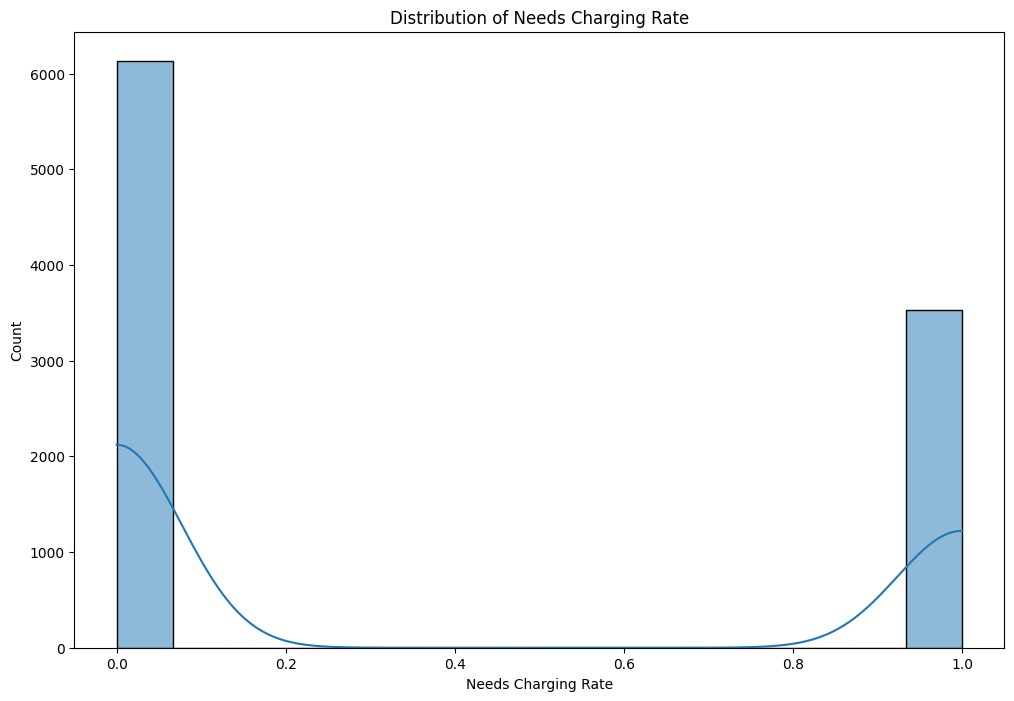

In [12]:
# Distribution of the target variable
plt.figure(figsize=(12,8))
sns.histplot(data['needs_charge'], kde=True)
plt.title('Distribution of Needs Charging Rate')
plt.xlabel('Needs Charging Rate')
plt.ylabel('Count')
plt.show()

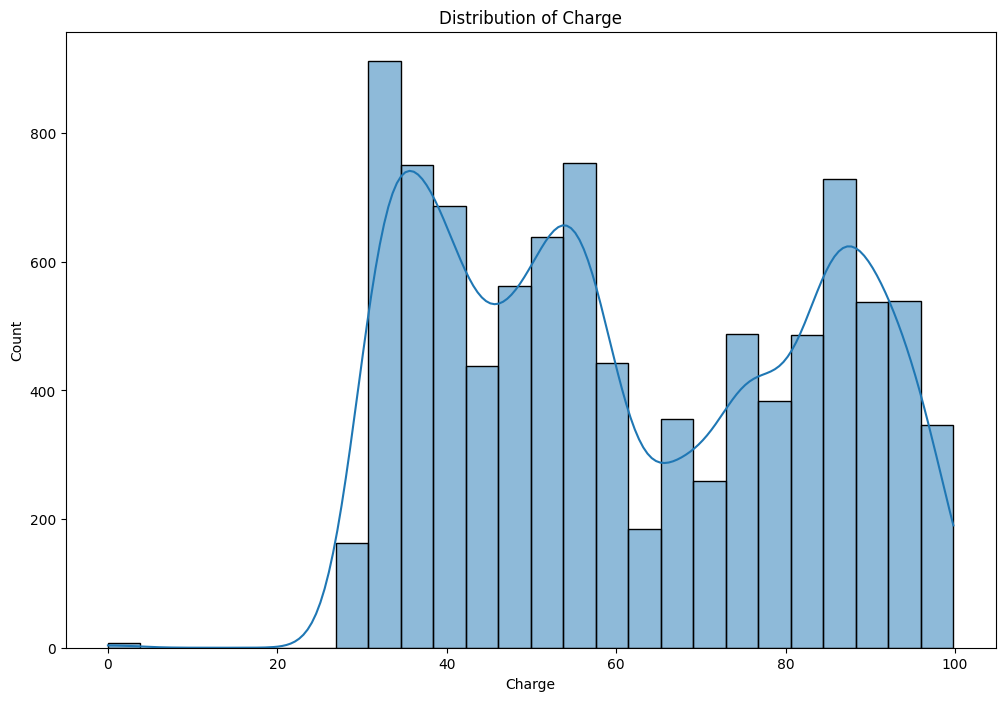

In [13]:
# plot the distribution 
plt.figure(figsize=(12,8))
sns.histplot(data['charge'], kde=True)
plt.title('Distribution of Charge')
plt.xlabel('Charge')
plt.ylabel('Count')
plt.show()


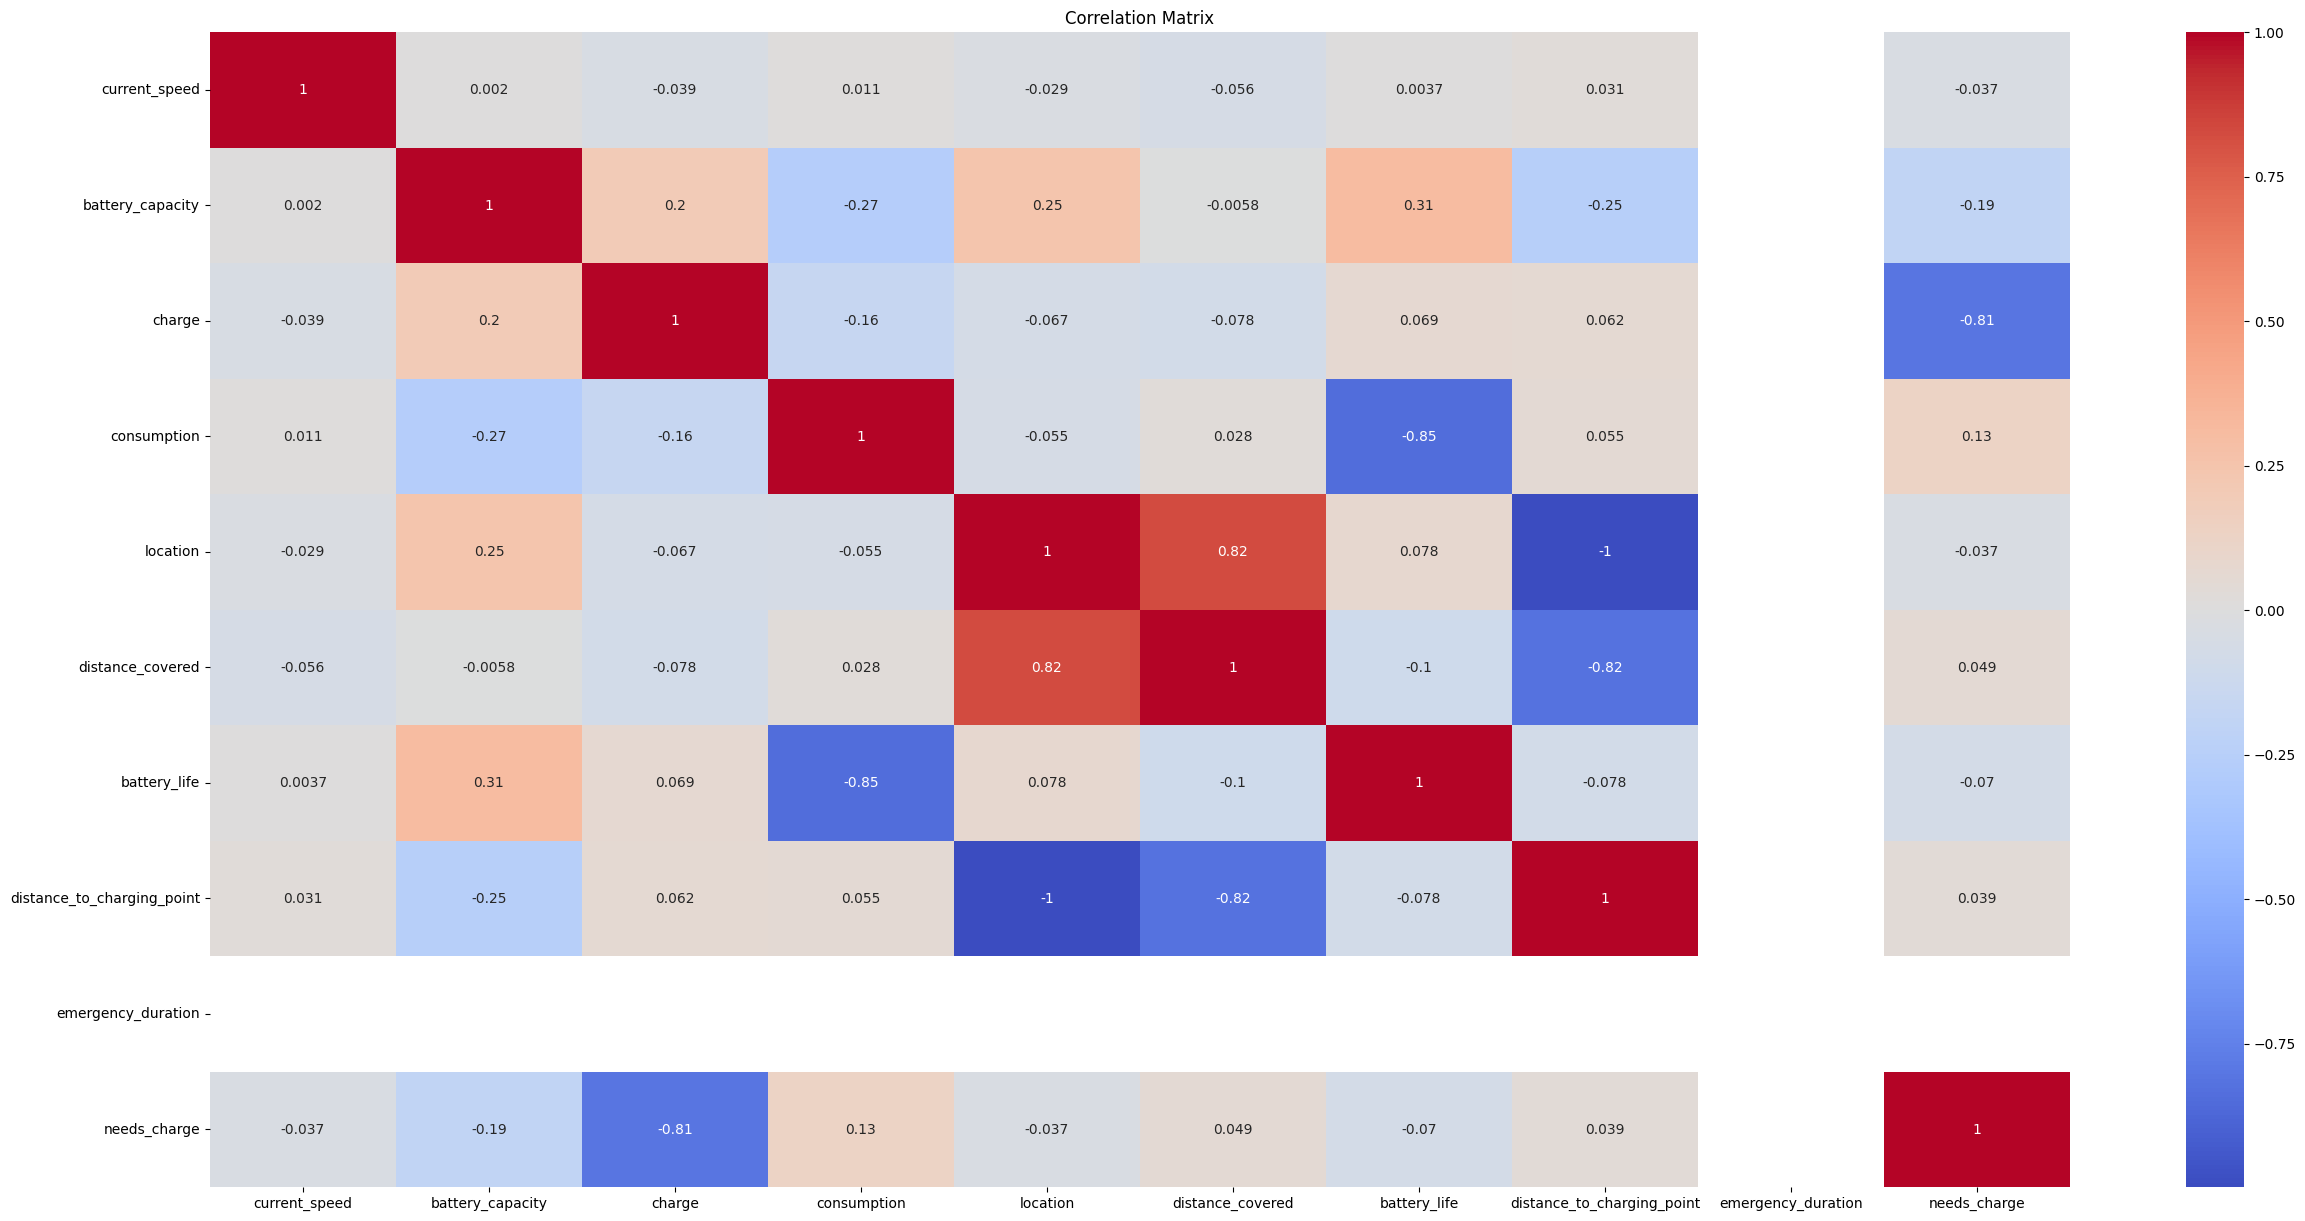

In [14]:
## Correlation Analysis
correlation_matrix = data.corr()
plt.figure(figsize=(30,15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

/home/maith/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


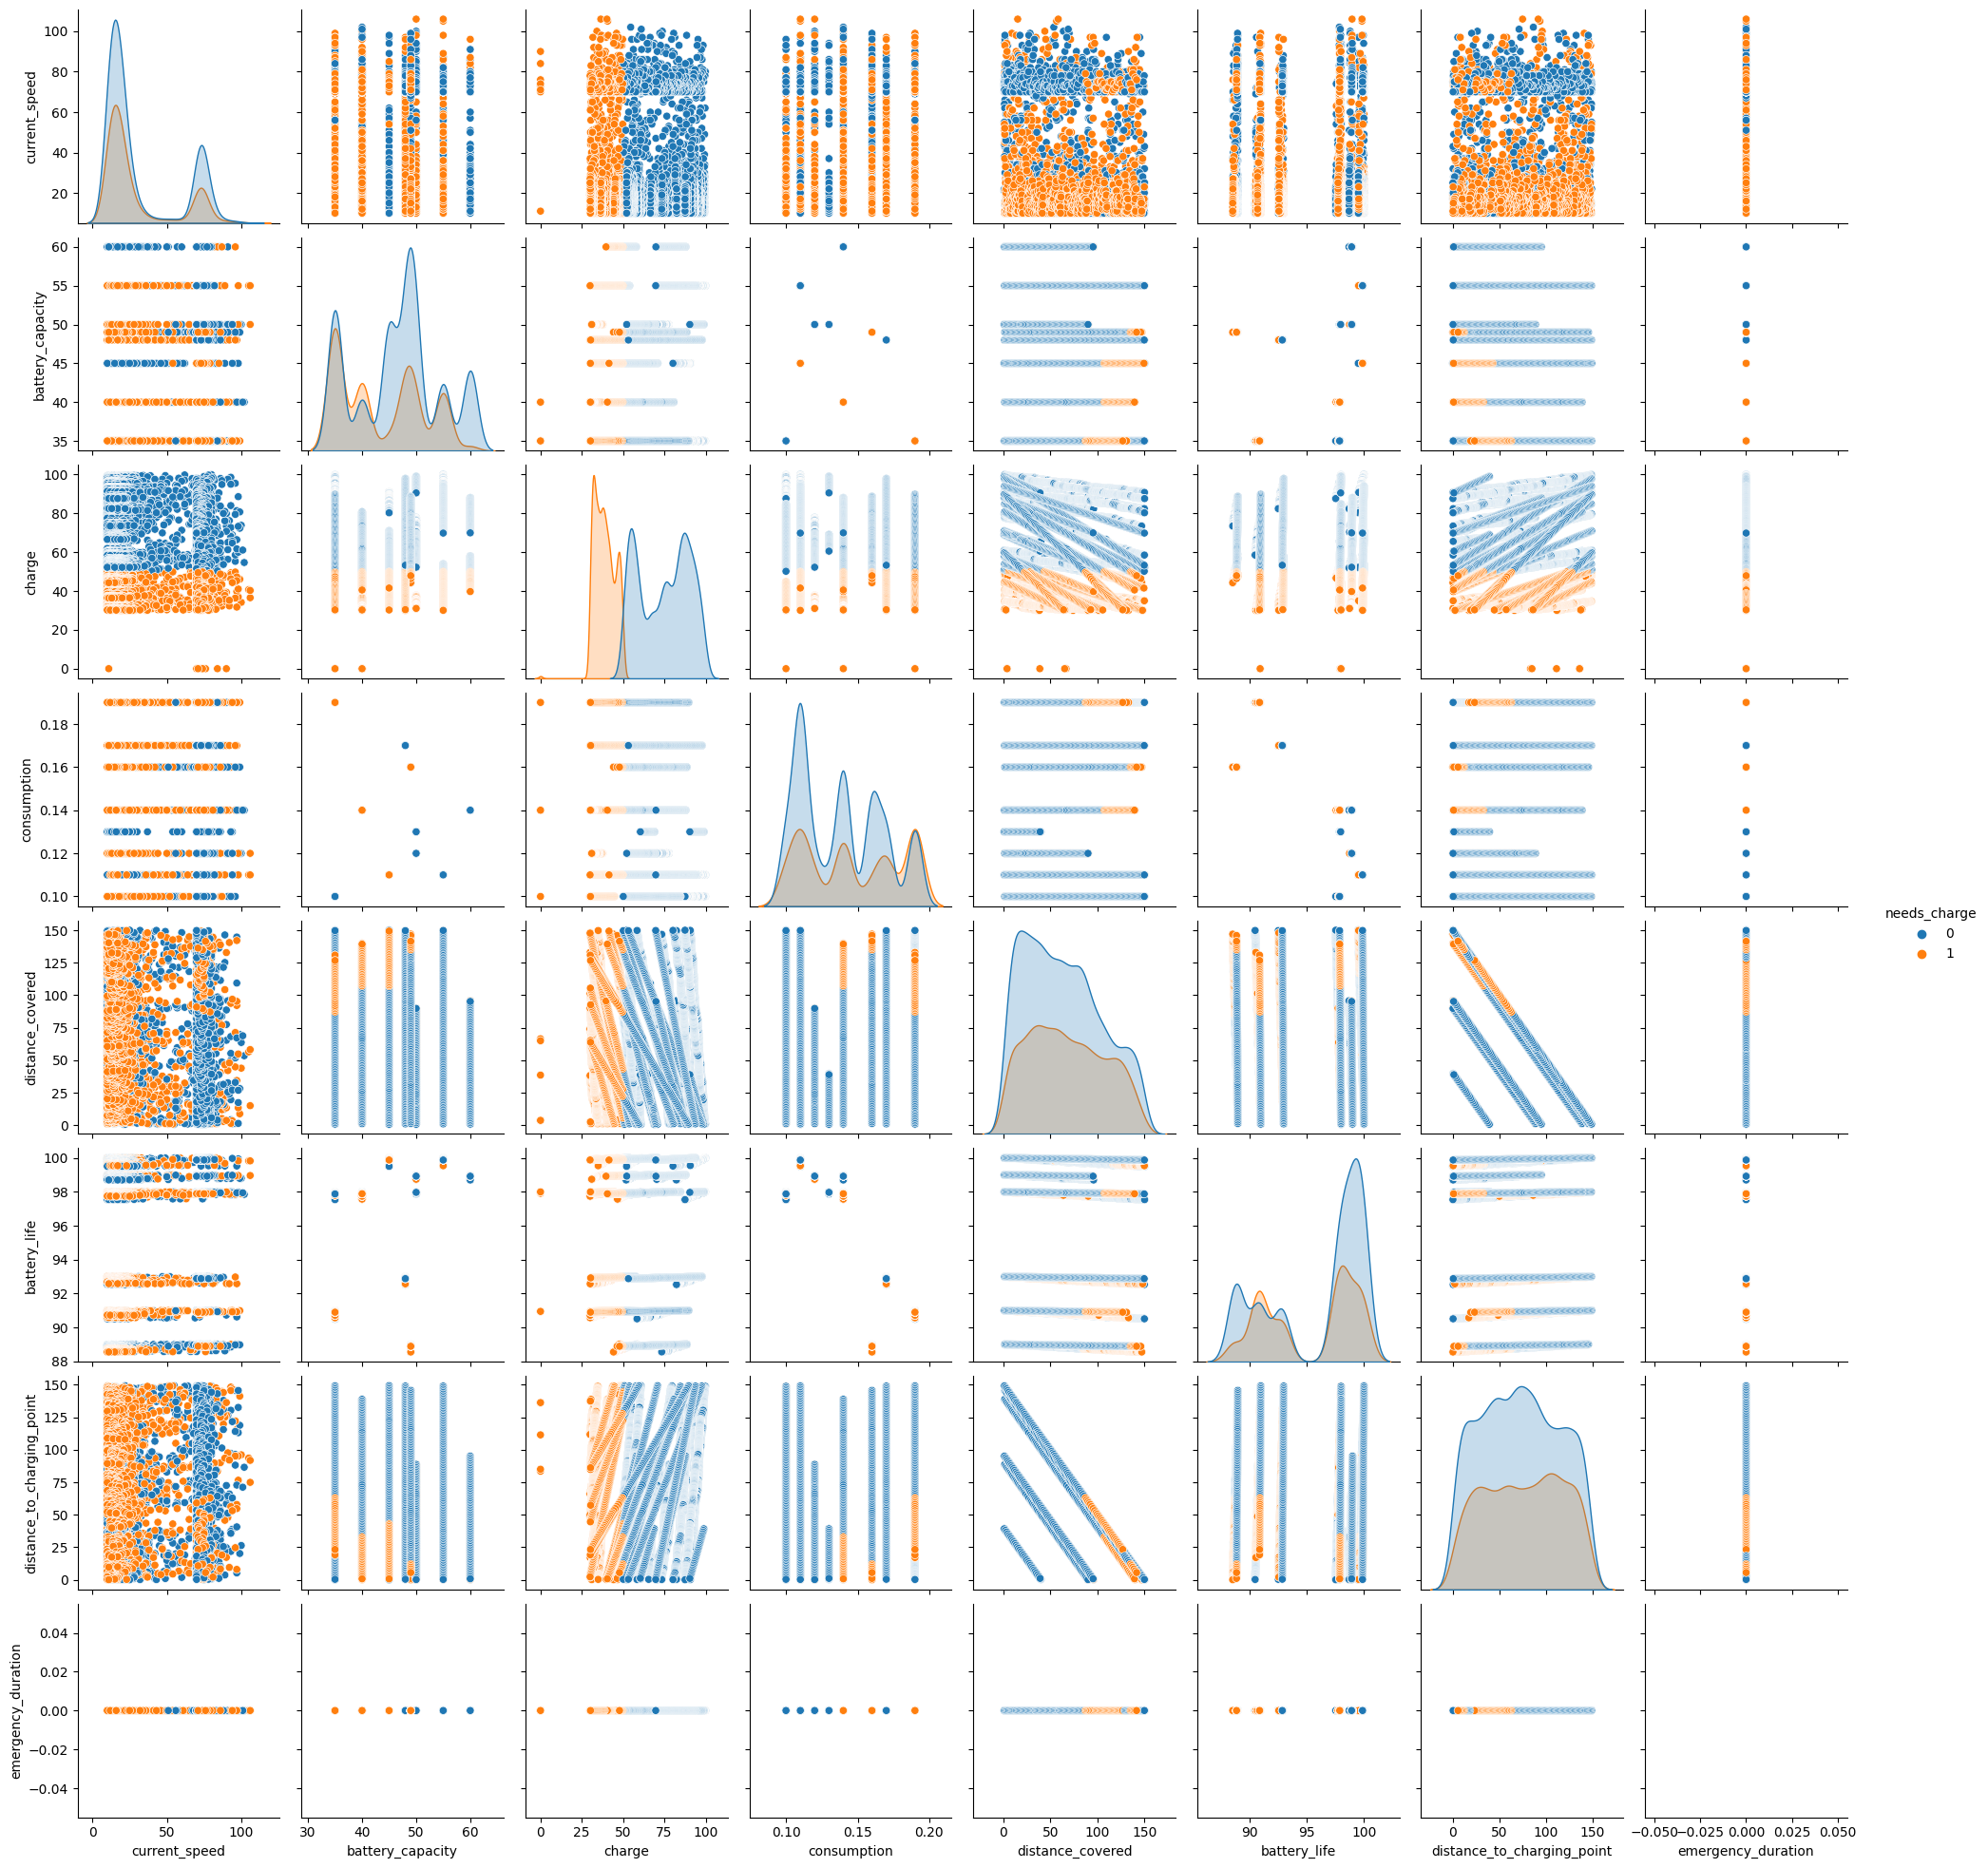

In [15]:
# Pairplot of the features and target variable
sns.pairplot(data[features + ['needs_charge']], hue='needs_charge')
plt.show()

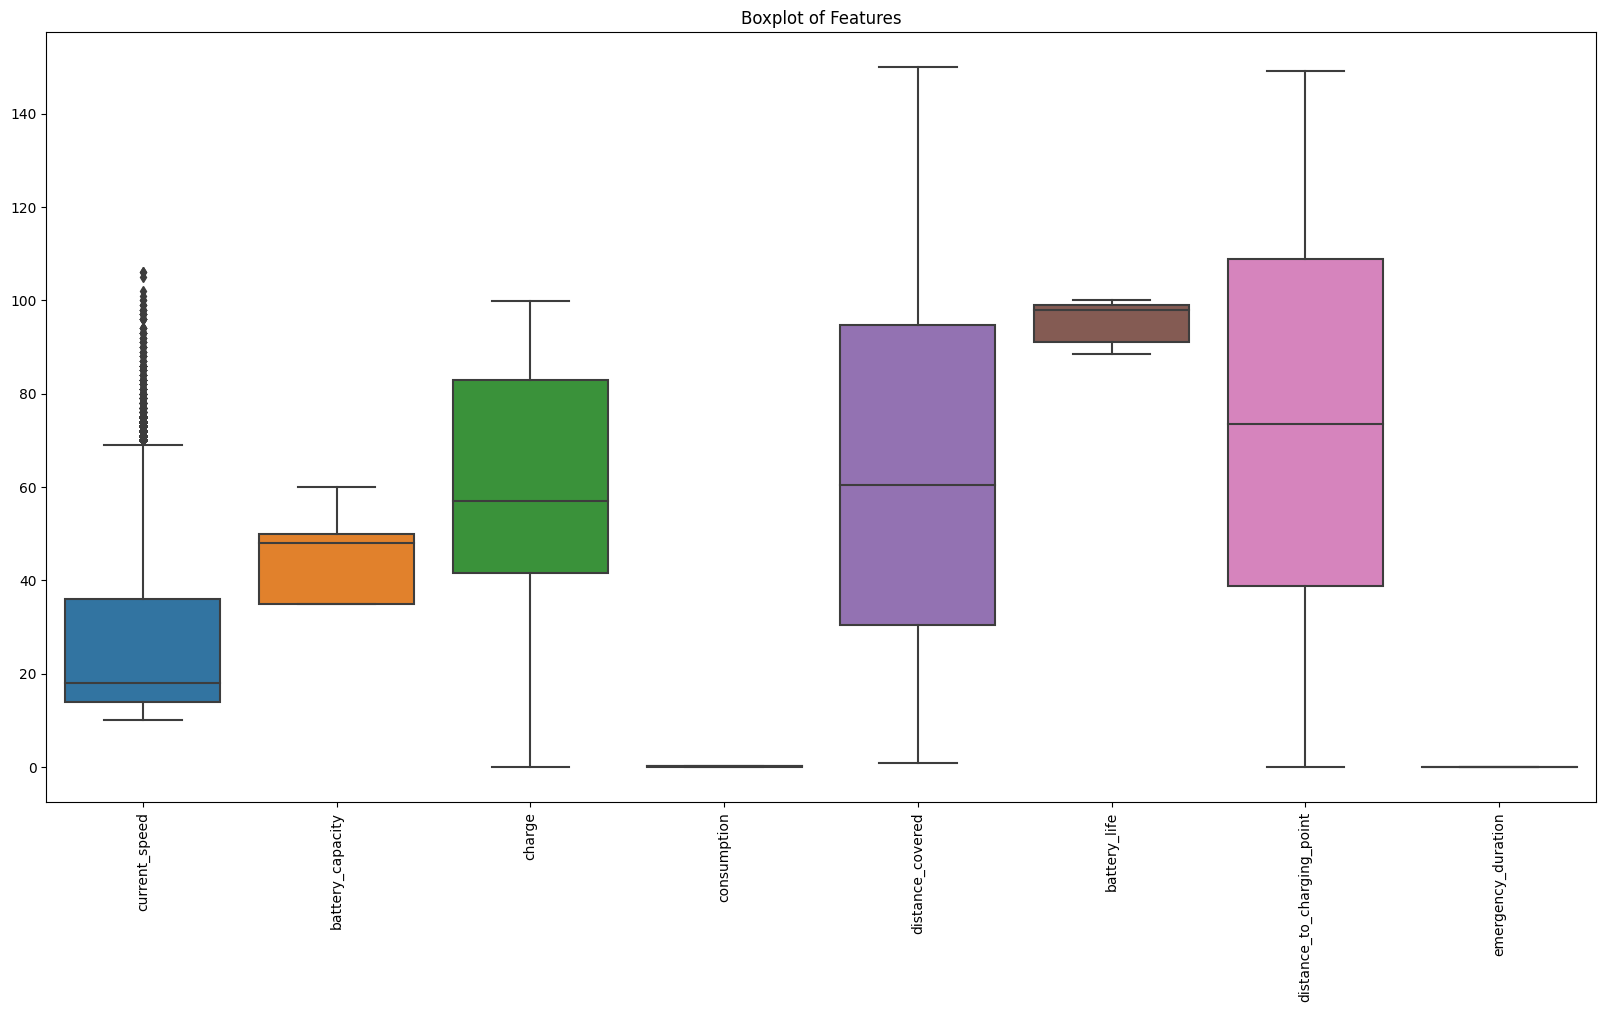

In [16]:
# Boxplots for each feature
plt.figure(figsize=(20, 10))
sns.boxplot(data=data[features])
plt.title('Boxplot of Features')
plt.xticks(rotation=90)
plt.show()

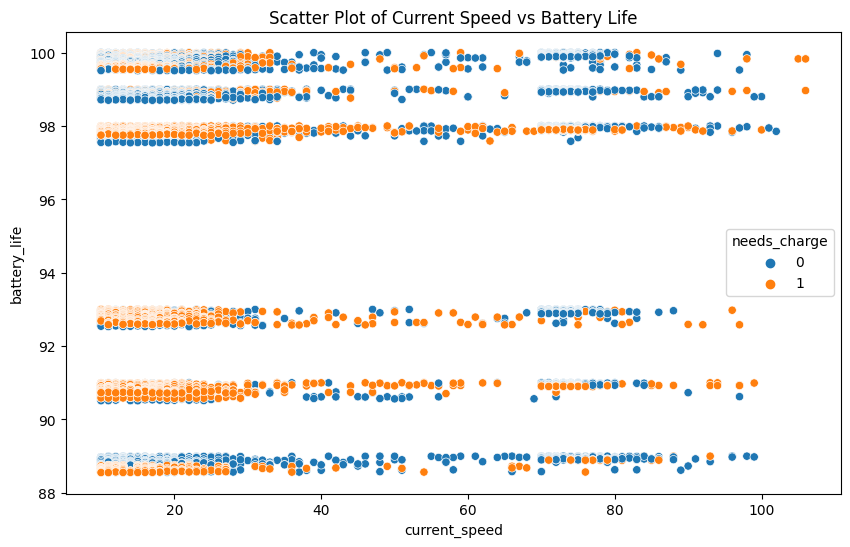

In [17]:
# Scatter plots
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='current_speed', y='battery_life', hue='needs_charge')
plt.title('Scatter Plot of Current Speed vs Battery Life')
plt.show()

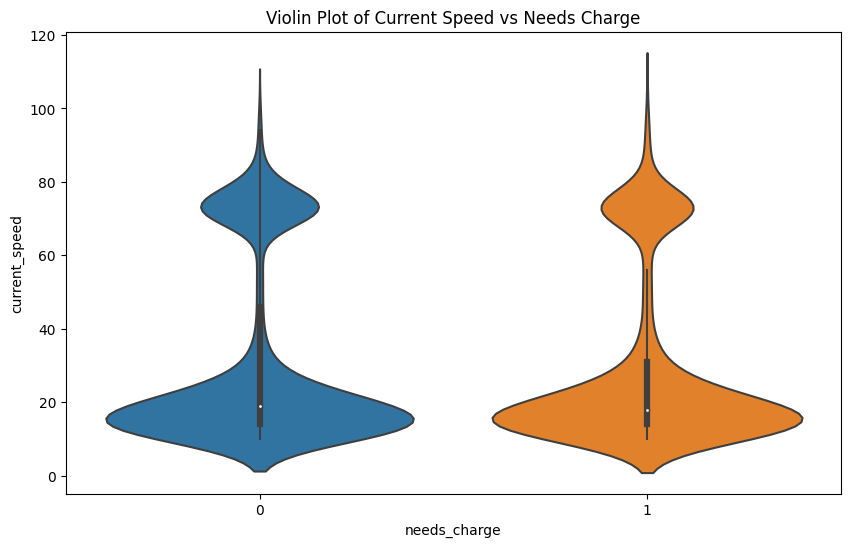

In [18]:
# Violin plots
plt.figure(figsize=(10, 6))
sns.violinplot(x=data['needs_charge'], y=data['current_speed'])
plt.title('Violin Plot of Current Speed vs Needs Charge')
plt.show()

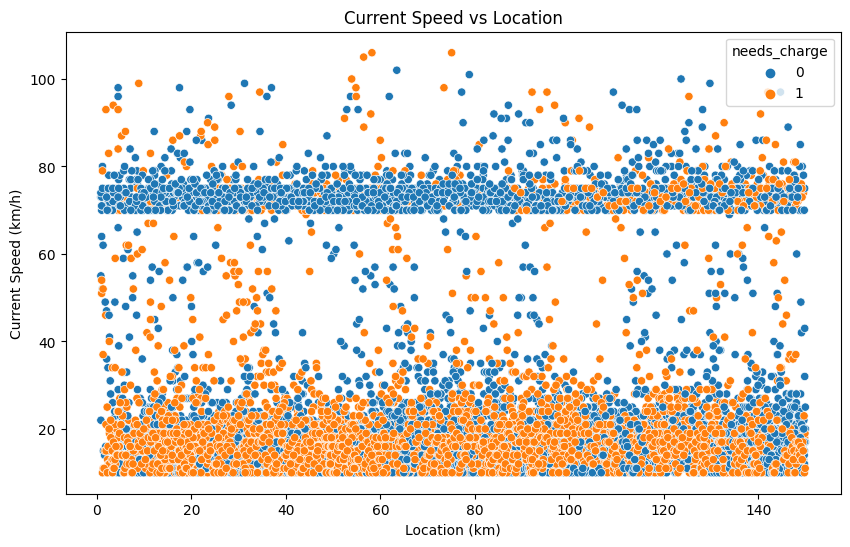

In [19]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='location', y='current_speed', hue='needs_charge')
plt.title('Current Speed vs Location')
plt.xlabel('Location (km)')
plt.ylabel('Current Speed (km/h)')
plt.show()

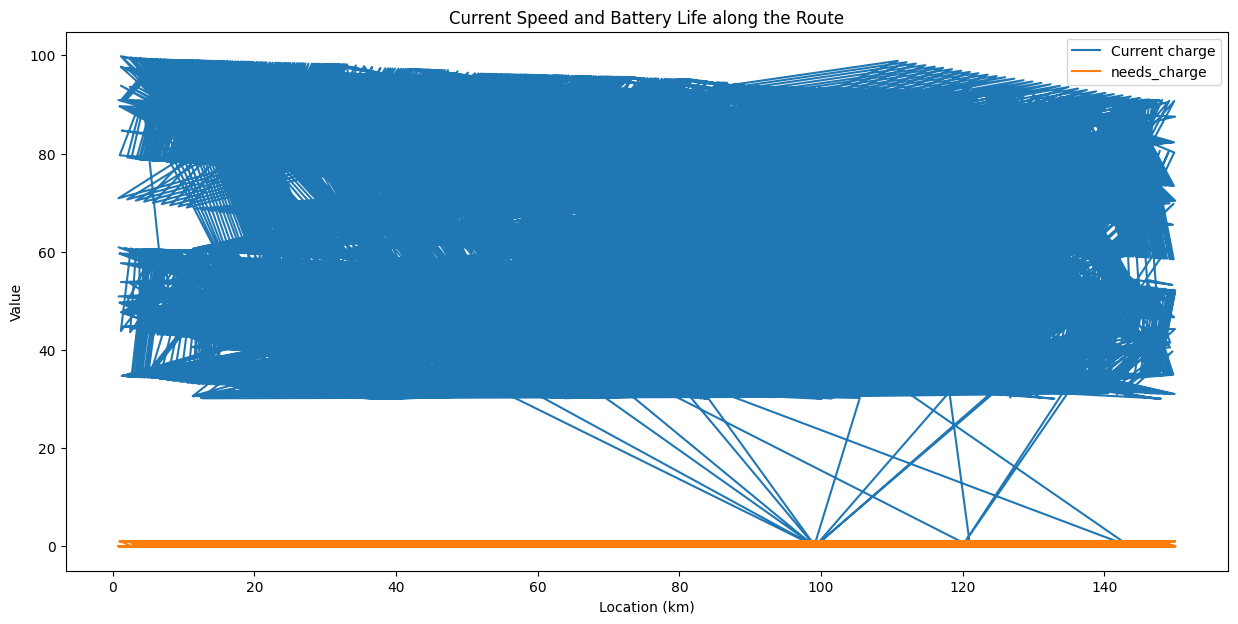

In [20]:
plt.figure(figsize=(15, 7))
plt.plot(data['location'], data['charge'], label='Current charge')
plt.plot(data['location'], data['needs_charge'], label='needs_charge')
plt.title('Current Speed and Battery Life along the Route')
plt.xlabel('Location (km)')
plt.ylabel('Value')
plt.legend()
plt.show()

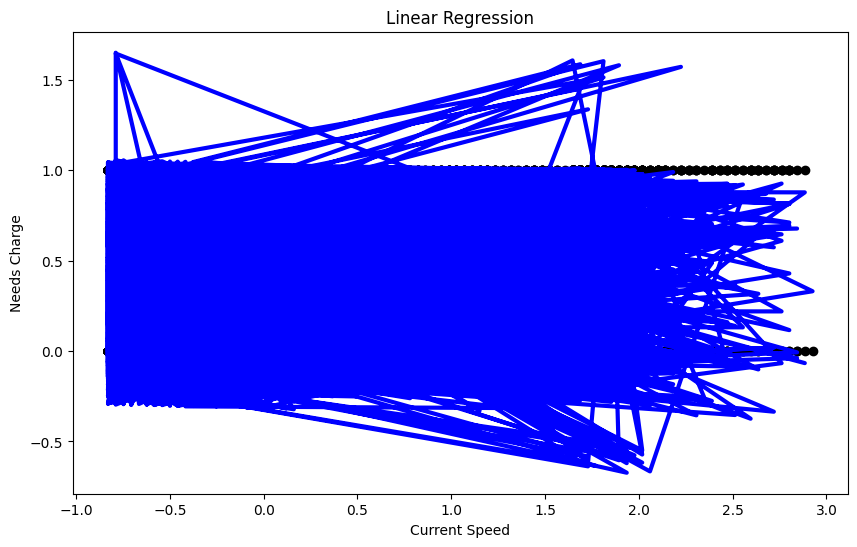

Accuracy: 0.89
              precision    recall  f1-score   support

        -1.0       0.00      1.00      0.00         0
         0.0       1.00      0.82      0.90      1839
         1.0       0.77      1.00      0.87      1060
         2.0       0.00      1.00      0.00         0

    accuracy                           0.89      2899
   macro avg       0.44      0.95      0.44      2899
weighted avg       0.92      0.89      0.89      2899



['linearReg_scaler_node1.pkl']

In [21]:
# Linear Regression
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Initialize the model
model = LinearRegression()

# Fit the model
model.fit(X_train_scaled, y_train_resampled)

# visualize
plt.figure(figsize=(10, 6))
plt.scatter(X_train_scaled[:, 0], y_train_resampled, color='black')
plt.plot(X_train_scaled[:, 0], model.predict(X_train_scaled), color='blue', linewidth=3)
plt.title('Linear Regression')
plt.xlabel('Current Speed')
plt.ylabel('Needs Charge')
plt.show()

# Make predictions
predictions = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions.round())

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
report = classification_report(y_test, predictions.round(), zero_division=1)
print(report)

# save the model
joblib.dump(model, 'linearReg_model_node1.pkl')
joblib.dump(scaler, 'linearReg_scaler_node1.pkl')